# Assessing JWST Data for Observatory or Guiding Issues

### Introduction

You may be an observer or archival investigator interested in a pursuing a research project with JWST data. You have <A HREF="https://jwst-docs.stsci.edu/accessing-jwst-data#gsc.tab=0">found and downloaded the data</A> and may have done some cursory assessment and analysis of the data. Based on this, you are wondering if there may some issue with the data. Maybe your research is particularly sensitive to observatory or point spread function (PSF) issues, such as for <A HREF="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#gsc.tab=0">exoplanet transit transit time series observations or <A HREF="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-high-contrast-imaging/jwst-high-contrast-imaging-proposal-planning/hci-coronagraphic-sequences#gsc.tab=0">differential coronography</A>. Or maybe you have library PSFs from another program or target, and you are puzzled why the PSFs don't fit as well as you would have expected. So you wonder if there may have been some issue with the observatory or the guiding during your observation. This notebook provides a top-level introduction to some available tools and common strategies for how to investigate this. It is not intended to address the most complex science use cases, but should help get you started in troubleshooting any issues, or convincing yourself that there are none.

### Setup

First we perform setup by importing packages and/or functions that we will need.

In [1]:
from misc_jwst import visit_status
from misc_jwst import guiding_analyses
from misc_jwst import mast
import webbpsf

### Visit Status

As a first example, let's assume that you have used the <A HREF="https://mast.stsci.edu/search/ui/#/jwst/">JWST Mission Search</A> in MAST to search for datasets on the dwarf Spheroidal galaxy Andromeda I. This should yield results similar to the following screenshot:

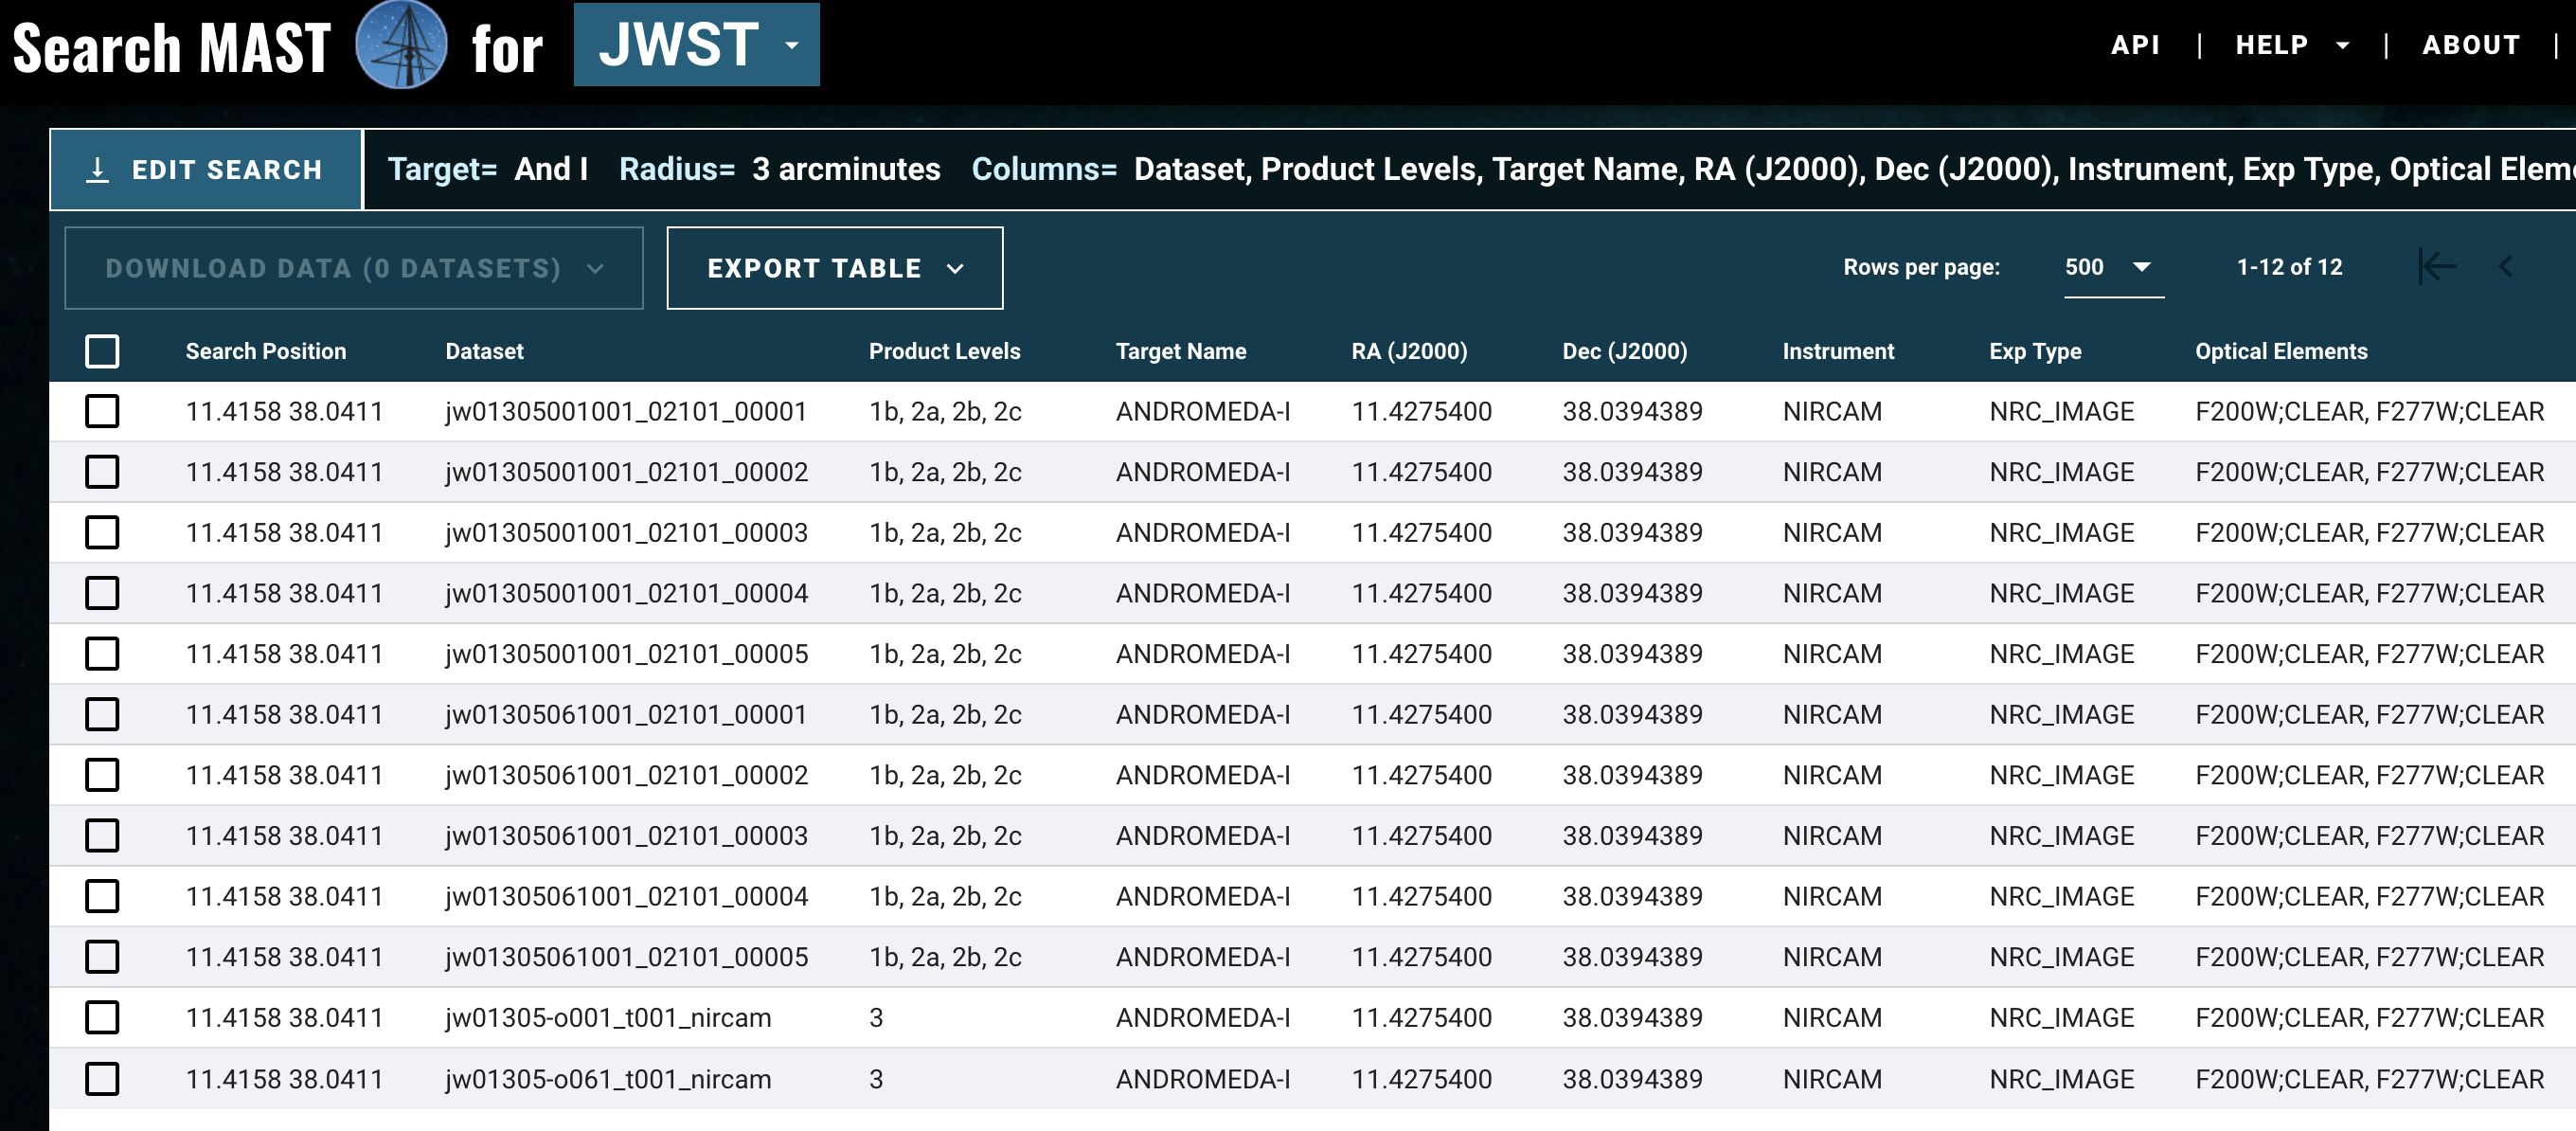

It has identified various datasets with names that start with either <b><span style="font-family:Courier">jw01305001001</span></b> or <b><span style="font-family:Courier">jw01305061001</span></b>. Given the <A HREF="https://jwst-docs.stsci.edu/accessing-jwst-data/jwst-science-data-overview#JWSTScienceDataOverview-Filenamingconventions">JWST file naming conventions</A>, this implies that the data come from program number 1305. And the data comes from visits with IDs <b><span style="font-family:Courier">V01305001001</span></b> or <b><span style="font-family:Courier">V01305061001</span></b>, where the initial capital "V" indicates that it is a visit identifier. A common thing to check first is whether any of the visits are actually marked as having failed. This can be found in the Program Information database at <A HREF="https://www.stsci.edu/jwst/science-execution/program-information">https://www.stsci.edu/jwst/science-execution/program-information</A>, by searching for the program ID number 1305. However, maybe you have a lot of visits to go through, or you may want to easily share your methods and results with collaborators. It is then more convenient to query the database by python calls that use functions in the <A HREF="https://github.com/mperrin/misc_jwst">misc_jwst</A> toolset.      

<span style="color:red">TBD: Is there any way to find out directly from the MAST search and database whether a visit is marked as "Failed"? It is not listed in the search results of the JWST Mission Search Form as far as I can tell.</span> 

<span style="color:red">TBD: The PI gets an Exception Report emailed when there is some anomaly with the data. Is there a way for other people in the community to find and search these reports?</span> 

We start with the first visit ID:

In [2]:
visit_status.query_program_status_form_visitid('V01305001001')

,Observation,Visit,Status,Target(s),Templates,Hours,Start Time (UT),End Time (UT),Repeat
0,1,1,Failed Archived,ANDROMEDA-I,NIRCam Imaging,1.13,"Jul 28, 2022 21:17:49","Jul 28, 2022 22:30:30",Rescheduled as visit 1305:51:1 (WOPR 88583)


This tells us that even though the data from this visit are available in the Archive, they are marked as "Failed". So in most cases you will not want to use these data. However, note that this need not always be true. For example, maybe the PSF quality was inadequate for the science that the observing team had proposed. But maybe you are doing an archival study of the extended background light in the image that is not sensitive to the details of the PSF. When observations are marked as "Failed", they are usually repeated or rescheduled because the observing team filed a request through submission of a WOPR (<A HREF="https://jwst-docs.stsci.edu/observing-with-jwst#gsc.tab=0">Webb Observation Problem Report</A>) that was approved. This is indeed listed here, and the WOPR number is indicated. The contents of a WOPR are not generally publicly available. But if it is crucial to your science to understand why particular data are marked as Failed, you can send an email to <A HREF="https://jwst-docs.stsci.edu/jwst-help-desk#gsc.tab=0">Help Desk</A> with reference to the WOPR number, and they may be able to provide assistance. (In the present case, these Andromeda I data showed significant image persistence from preceeding observations of Jupiter.) We see that the images were rescheduled with visit identifier 1305:51:1, but we didn't find any data for this in the Archive. So we investigate this visit:           

In [3]:
visit_status.query_program_status_form_visitid('V01305051001')

,Observation,Visit,Status,Target(s),Templates,Hours,Start Time (UT),End Time (UT),Repeat
8,51,1,Skipped,ANDROMEDA-I,NIRCam Imaging,1.54,NaN,NaN,Rescheduled as visit 1305:61:1 (WOPR 88679) ...


So this visit had been scheduled, but was skipped. (In the present case, because a science instrument needed for the visit was not available.) Another WOPR was filed and approved, and the observations were rescheduled again. This time they succeeded:

In [4]:
visit_status.query_program_status_form_visitid('V01305061001')

,Observation,Visit,Status,Target(s),Templates,Hours,Start Time (UT),End Time (UT),Repeat
7,61,1,Archived,ANDROMEDA-I,NIRCam Imaging,1.54,"Aug 3, 2023 19:21:14","Aug 3, 2023 20:16:37",Repeat of visit 1305:51:1 (WOPR 88679)


So in the present case, we'll likely want to use the datasets from MAST that start with <b><span style="font-family:Courier">jw01305061001</span></b>, but not those that start with <b><span style="font-family:Courier">jw01305001001</span></b>.
If you find that easier, it also possible extract and display all the visit status information from the program at the same time:

In [5]:
visit_status.query_program_status_form(1305)

,Observation,Visit,Status,Target(s),Templates,Hours,Start Time (UT),End Time (UT),Repeat
0,1,1,Failed Archived,ANDROMEDA-I,NIRCam Imaging,1.13,"Jul 28, 2022 21:17:49","Jul 28, 2022 22:30:30",Rescheduled as visit 1305:51:1 (WOPR 88583)
1,2,1,Failed Archived,ANDROMEDA-III,NIRCam Imaging,1.12,"Jul 28, 2022 22:30:34","Jul 28, 2022 23:31:14",Rescheduled as visit 1305:52:1 (WOPR 88583)
2,3,1,Failed Archived,ANDROMEDA-XIV,NIRCam Imaging,1.45,"Jul 28, 2022 23:31:18","Jul 29, 2022 00:27:18",Rescheduled as visit 1305:53:1 (WOPR 88583)
3,4,1,Failed Archived,ANDROMEDA-XVII,NIRCam Imaging,1.45,"Jul 29, 2022 00:27:22","Jul 29, 2022 01:29:14",Rescheduled as visit 1305:54:1 (WOPR 88583)
4,53,1,Archived,ANDROMEDA-XIV-UPDATED,NIRCam Imaging,1.54,"Dec 6, 2022 14:39:54","Dec 6, 2022 15:51:11",Repeat of visit 1305:3:1 (WOPR 88583)
5,52,1,Archived,ANDROMEDA-III,NIRCam Imaging,1.24,"Jan 10, 2023 17:38:02","Jan 10, 2023 18:48:14",Repeat of visit 1305:2:1 (WOPR 88583)
6,64,1,Archived,ANDROMEDA-XVII,NIRCam Imaging,1.13,"Aug 3, 2023 17:53:18","Aug 3, 2023 19:21:10",Repeat of visit 1305:54:1 (WOPR 88679)
7,61,1,Archived,ANDROMEDA-I,NIRCam Imaging,1.54,"Aug 3, 2023 19:21:14","Aug 3, 2023 20:16:37",Repeat of visit 1305:51:1 (WOPR 88679)
8,51,1,Skipped,ANDROMEDA-I,NIRCam Imaging,1.54,NaN,NaN,Rescheduled as visit 1305:61:1 (WOPR 88679) ...
9,54,1,Skipped,ANDROMEDA-XVII,NIRCam Imaging,1.16,NaN,NaN,Rescheduled as visit 1305:64:1 (WOPR 88679) ...


### Telescope Alignment

We have now identified which Andromeda I datasets to focus on. Say we want to do PSF-fitting point source photometry and/or astrometry. Before we go about and invest much time in this, we want to make sure that there was nothing anomalous with the observatory during the time of the observations. A first thing to assess is the focus and alignment state of the JWST telescope mirrors. JWST has a lightweight segmented primary mirror composed of 18 distinct segments attached to a common backplane structure. These were brought into focus during telescope commissioning. But periodic adjustments are necessary to keep the segments aligned. Mostly this is to counteract slow thermal drifts, but occasionally there are sudden bigger disruptions that may affect image quality. The <A HREF="https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/psf-simulation-tool">STPSF</A> package (formerly WebbPSF) contains tools to retrieve and display the periodic (every few days) Wave Front Sensing (WFS) results used to monitor the telescope alignment. Here we use only a few features of STPSF, but more detailed tutorials can be found in <A HREF="https://www.stsci.edu/jwst/science-execution/jwebbinars">JWebbinar #34</A> (expand "Materials and Videos") and a <A HREF="https://spacetelescope.github.io/jdat_notebooks/notebooks/cross_instrument/stpsf_examples/stpsf_examples.html">dedicated STPSF notebook</A>. The data of interest to us were obtained on August 3, 2023. So we reterive the monitoring results for that month, list the results in tabular form, and create some plots. Note that STPSF will download and install some reference data that it needs, if this isn't already present on your system.

<span style="color:red">TBD: Replace WebbPSF calls by STPSF calls.</span> 

2025-06-16 10:44:24,133 - stpipe - WARNING - /Users/marel/anaconda3/envs/TelTools/lib/python3.12/site-packages/webbpsf/utils.py:241: UserWarning: Environment variable $WEBBPSF_PATH is not set!

 ***********  ERROR  ******  ERROR  ******  ERROR  ******  ERROR  ***********
 *                                                                          *
 *  WebbPSF requires several data files to operate.                         *
 *  These files could not be located automatically at this time, or this    *
 *  version of the software requires a newer set of reference files than    *
 *  you have installed.  For more details see:                              *
 *                                                                          *
 *        https://webbpsf.readthedocs.io/en/stable/installation.html        *
 *                                                                          *
 *  under "Installing the Required Data Files".                             *
 *  WebbPSF will not be ab

Date,Filename,WFS Type,RMS WFE (OTE+SI),RMS WFE (OTE only),EE(2.5 pix),EE(10pix)
,,,nm,nm,,
str23,str29,str7,float64,float64,float64,float64
2023-07-31T00:53:27.200,O2023073101-NRCA3_FP1-1.fits,Sensing,69.83299763160454,61.98538629064123,0.6722096195390934,0.8770591197467315
2023-08-02T10:39:41.000,O2023080201-NRCA3_FP1-1.fits,Sensing,69.02142307714368,61.57831893320763,0.6721350061328366,0.8775648868767143
2023-08-04T07:53:27.200,O2023080401-NRCA3_FP1-1.fits,Sensing,68.46373841661293,61.54815775020111,0.6720704548943028,0.8775080323105169
2023-08-06T08:46:09.300,O2023080601-NRCA3_FP1-1.fits,Sensing,69.24244526450066,62.00427332997172,0.6718404766703607,0.8774033327307615
2023-08-08T23:04:48.300,O2023080901-NRCA3_FP1-1.fits,Sensing,69.0054333130766,62.050453237292196,0.6714100883788888,0.8774967534863074
2023-08-11T01:24:34.700,O2023081101-NRCA3_FP1-1.fits,Sensing,70.47718454869556,63.24661589953759,0.670101354600265,0.877272748585605
2023-08-12T22:58:35.400,R2023081302-NRCA3_FP1-1.fits,Sensing,70.28312306896746,63.18642355612449,0.6705068853746873,0.8772771812657196
2023-08-14T07:06:20.700,R2023081402-NRCA3_FP1-1.fits,Sensing,72.18520837081238,64.43650353918768,0.6703616908605612,0.8767117799511007


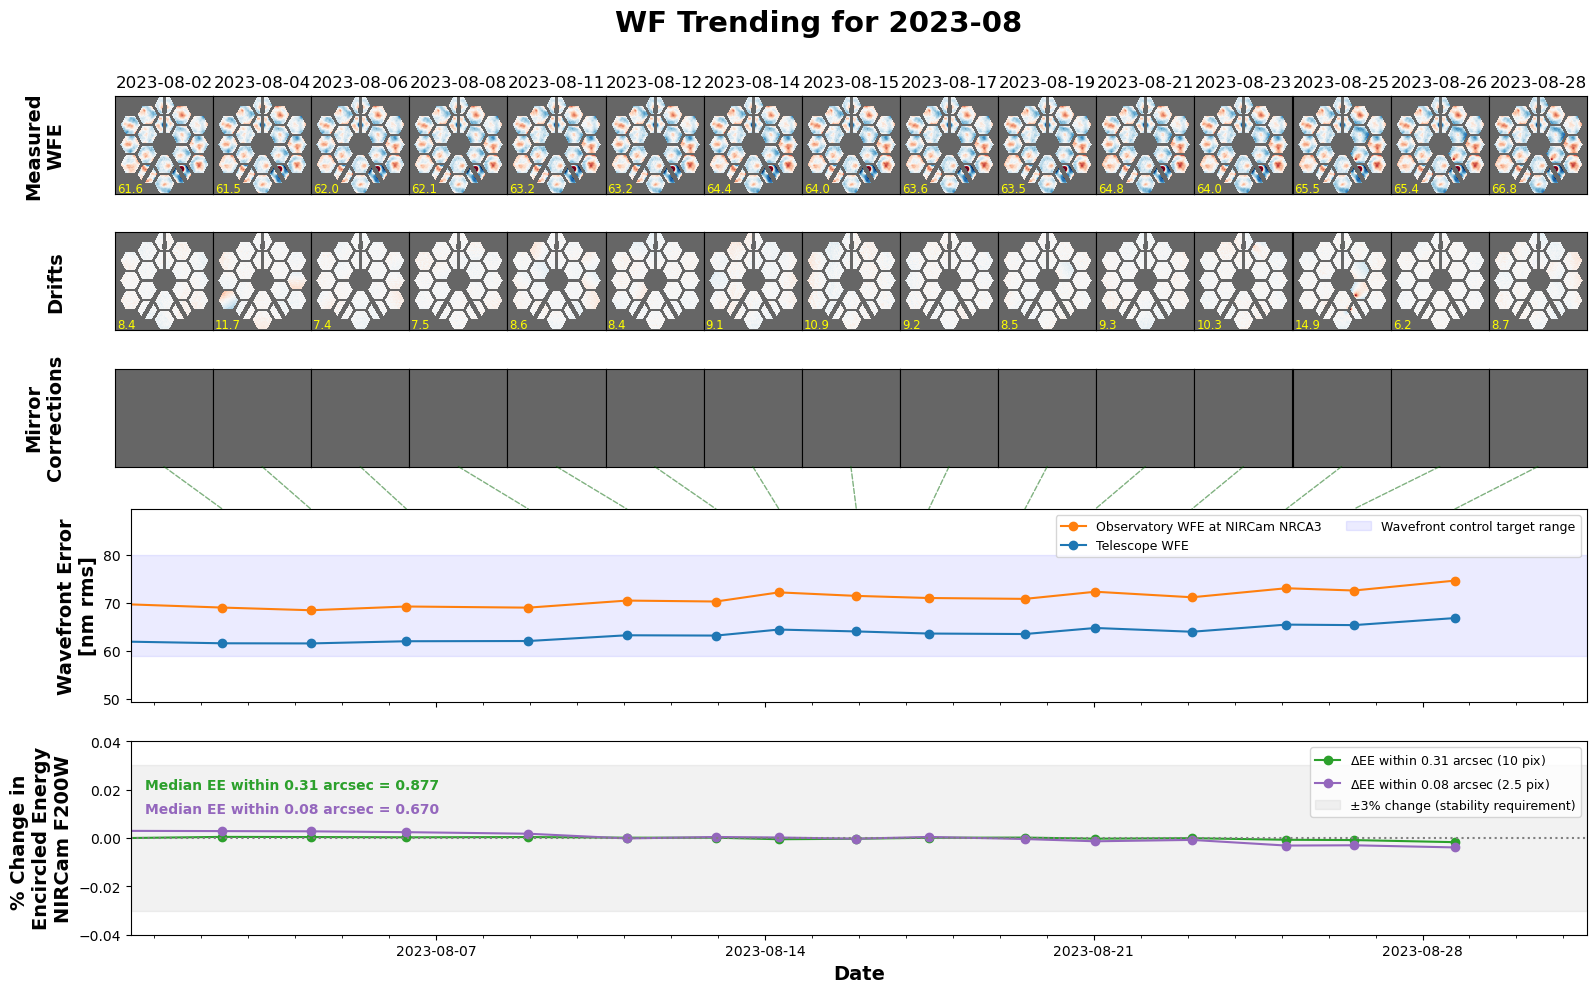

In [6]:
trend_table = webbpsf.trending.monthly_trending_plot(2023, 8, verbose=False)
trend_table

The columns show the RMS Wavefront Error (WFE) in nm for the OTE-only and the NIRCam NRCA3 detector, as well as model-predicted PSF encircled energy values at 2 micron. The telescope was designed to be diffraction-limited at 2 micron, which corresponded to a pre-launch requirement on the OTE-only RMS WFE of 131 nm. Any value below this limit is generally good enough for science. However, above about 95 nm (and below 131 nm) observation repeats have been granted in exceptional instances for science that is particularly sensitive to PSF quality and variations (e.g., observations at very blue wavelengths or coronagraphic observations). There have only been two unusual excursions above 131 nm during the JWST operational phase, but this can happen (e.g., <A HREF="https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-008650.pdf">OTE Science Performance Memo 3</A>). In the present case, we see that telescope alignment and image quality were good and stable during the entire month of August 2023. For comparison, here is another month during which that was not the case.  

Date,Filename,WFS Type,RMS WFE (OTE+SI),RMS WFE (OTE only),EE(2.5 pix),EE(10pix)
,,,nm,nm,,
str23,str29,str16,float64,float64,float64,float64
2023-09-29T08:33:42.400,R2023092902-NRCA3_FP1-1.fits,Sensing,69.12347766918522,62.44135831333384,0.6720656444153904,0.8765909292309744
2023-10-01T07:55:21.200,R2023100103-NRCA3_FP1-1.fits,Sensing,69.19901997776708,62.56308809157073,0.6718818097177304,0.8765336601065412
2023-10-03T22:17:53.900,R2023100604-NRCA3_FP1-1.fits,Sensing,68.89000969617469,62.3832122181805,0.6720806417652984,0.8765862407170644
2023-10-05T09:00:19.700,O2023100601-NRCA3_FP1-1.fits,Sensing,68.74488003194617,62.45119369369938,0.6721819813781307,0.87660082564564
2023-10-07T22:35:25.100,R2023100801-NRCA3_FP1-1.fits,Sensing,83.63928919114987,75.26140724253924,0.6621104567031313,0.8754853314229764
2023-10-09T22:18:18.900,R2023101003-NRCA3_FP1-1.fits,Sensing,82.29049295277143,74.5130430664893,0.6625476399512837,0.875381760290987
2023-10-09T22:56:58.100,R2023101004-NRCA3_FP1-1.fits,Post Mirror Move,65.53695853733645,61.65693149743026,0.6721854903703293,0.8765724812675143
2023-10-12T06:53:15.400,R2023101301-NRCA3_FP1-0.fits,Sensing,96.13798921725216,96.50736856105773,0.6291607702159215,0.8650434753008682


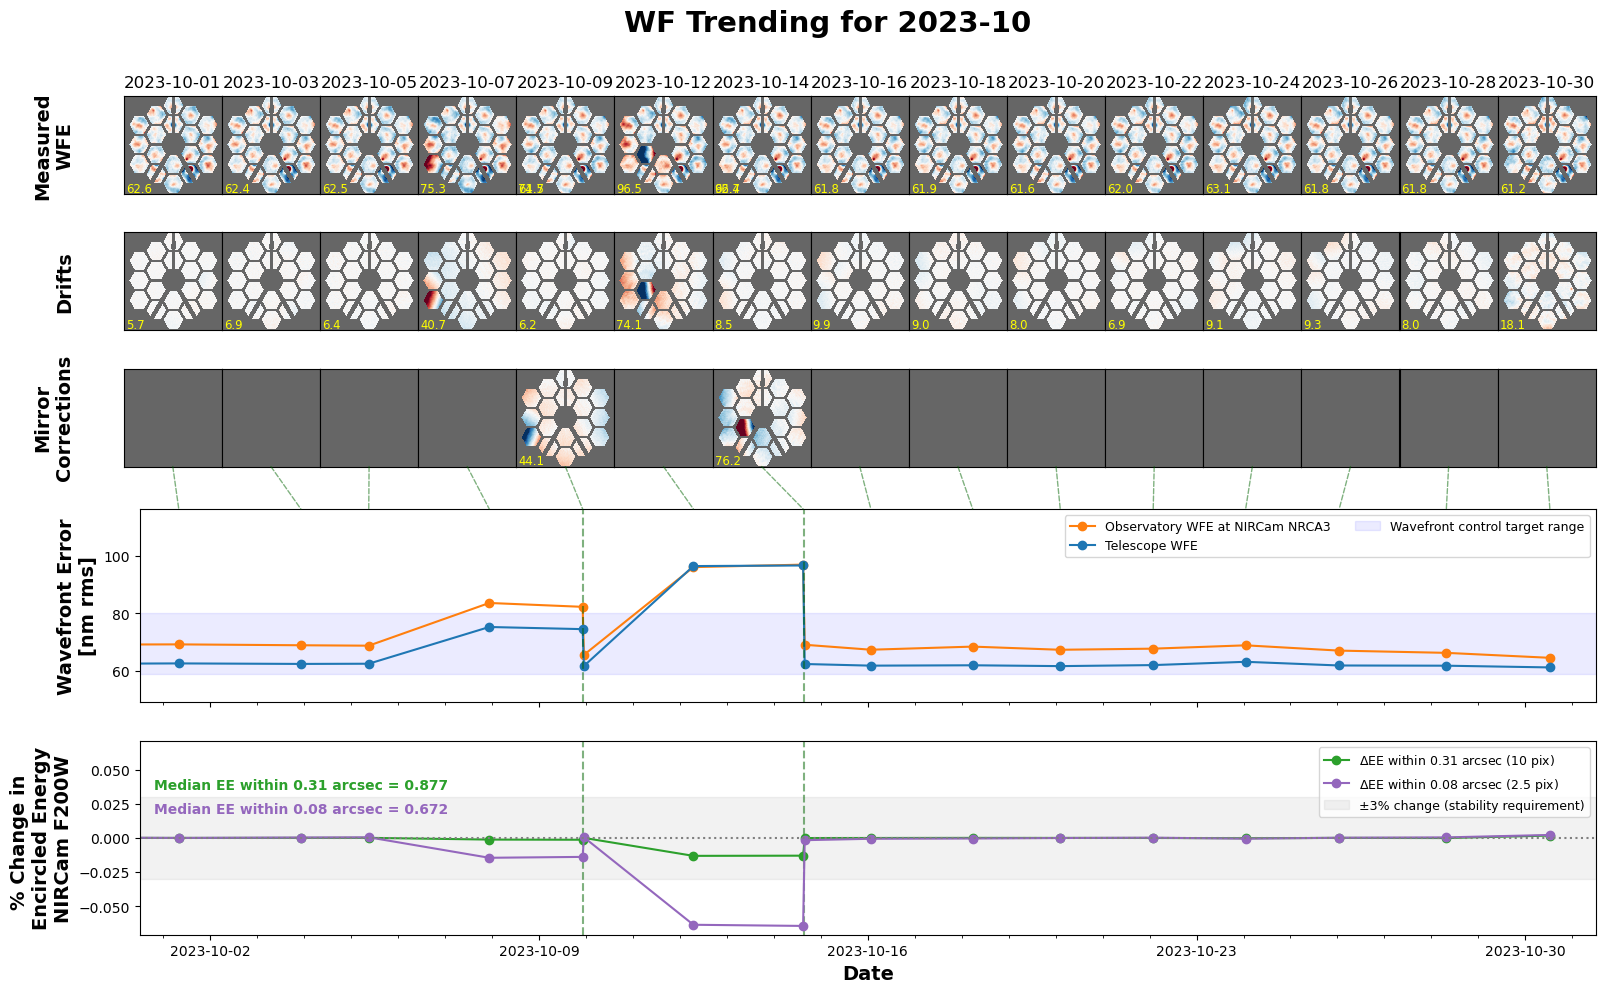

In [7]:
trend_table = webbpsf.trending.monthly_trending_plot(2023, 10, verbose=False)
trend_table

### Guiding Characteristics

The next thing to check is if there were any anomalies in the guiding of the telescope during the observations. To assess this, we use more functions from the same misc_jwst package discussed above. When we did the MAST JWST Mission Search for Andromeda I above, it indicated that 5 exposures are available from visit ID <b><span style="font-family:Courier">V01305061001</span></b>. We download here the first of these images, just for NIRCam's A3 detector. This requires that you have a <A HREF="https://jwst-docs.stsci.edu/accessing-jwst-data/mast-api-access#gsc.tab=0">MAST API Token</A>, and that this has been set in a system evironment variable 
called <b><span style="font-family:Courier">MAST_API_TOKEN</span></b>. If you already downloaded the data file from MAST previously, then this step can be skipped. 


<span style="color:red">TBD: Is there a way to download public data without requiring a token?</span>

In [8]:
sci_filename = 'jw01305061001_02101_00001_nrca3_rate.fits'
mast.get_mast_filename(sci_filename)

 ALREADY DOWNLOADED: ./jw01305061001_02101_00001_nrca3_rate.fits


<span style="color:red">TBD: Before downloading the guding files, we first want to show how to do the following: (1) Display the GDSTARID keyword to show what guide star was used for this exposure. Refer to https://stsci-docs.stsci.edu/display/JDOX/.JWST+Guide+Stars+v4.0 for a discussion of JWST Guide Star selection; and (2) Display the VISITSTA keyword to show whether there was a guiding problem with the visit. Refer to https://stsci-docs.stsci.edu/display/JDOX/.JWST+Guiding+Errors+and+Problems+v4.0 for a discussion of what the values of this keyword are, and what problems may occur.</span> 

Now use a function that takes as input a filename for some JWST science data product, and which then uses header information to look up from MAST the filename for the calibrated guiding data that corresponds to that time period. This file is then automatically downloaded from MAST into the current directory.

In [9]:
gs_filenames = guiding_analyses.find_relevant_guiding_file(sci_filename)

For science data file: jw01305061001_02101_00001_nrca3_rate.fits
Found guiding telemetry files:
    jw01305061001_gs-fg_2023215194900_cal.fits
    jw01305061001_gs-fg_2023215195537_cal.fits
    jw01305061001_gs-fg_2023215200214_cal.fits
    jw01305061001_gs-fg_2023215200851_cal.fits
    jw01305061001_gs-fg_2023215201545_cal.fits
Based on science DATE-END keyword and guiding timestamps, the matching GS file is: 
    jw01305061001_gs-fg_2023215194900_cal.fits
    t_end = 2023215194835	 delta = 65


100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 4877.10it/s]

ALREADY DOWNLOADED:  ./jw01305061001_gs-fg_2023215194900_cal.fits


Some longer exposures have guiding data split across multiple files, so the filenames are always returned as a list. In this case, there's only one guiding file found:

In [10]:
gs_filenames

['./jw01305061001_gs-fg_2023215194900_cal.fits']

For general applications, the most useful information provided by the guiding data is often the "jitter ball". This is a scatter plot that shows how the guide star moved around during the exposure within the guide box. The actual PSF of an observation can be thought of as a convolution of the PSF generated purely by the optics+instrument combination, and the jitter ball that characterizes the stability of the spacecraft pointing during the exposure.  

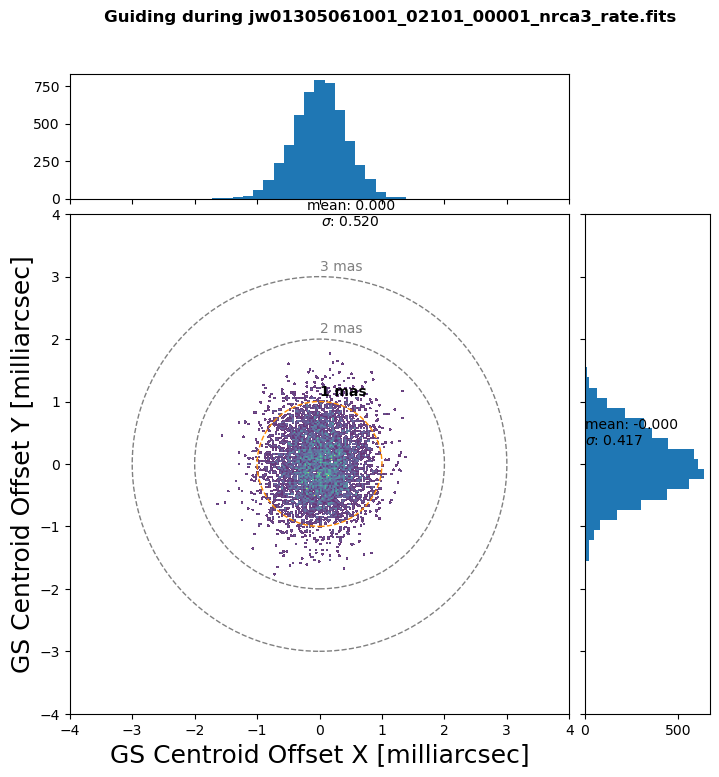

In [11]:
guiding_analyses.guiding_performance_jitterball(sci_filename)

The resulting plot shows that the guiding was very stable during the exposure. The RMS pointing jitter listed next to the histograms is only 0.4-0.5 mas along each axis. That is very small compared to the width of the PSF generated purely by the optics+instrument combination, and therefore does not materially impact to the final image quality. For reference,
the <A HREF="https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions#gsc.tab=0">PSF FWHM at 2 micron is about 65 mas</A>, and it scales roughly linearly with wavelength. The spacecraft jitter will only have a significant impact on the overall FWHM if the jitter ball if significantly asymmetric, or its width is a significant fraction of the PSF width (note that the two add in quadrature). 

The same procedure can be followed to make similar plots for the other science exposures of interest. Note that the jitter is measured on the Fine Guidance Sensor instrument. So it depends on the time interval of the observations, but not on what specific detector data is downloaded in the procedure above.

<span style="color:red">TBD: Consider including the python code at the end of https://stsci-docs.stsci.edu/display/JDOX/.JWST+Fine+Guide+Stability+v4.0 that shows how to create a jitter plot manually. With access to the individual arrays, usesr can calculate additional statistics or plots that may be of relevance to them.</span> 

<span style="color:red">TBD: Add the function call that shows all exposures within a visit.</span> 

<span style="color:red">TBD: Discuss misc_jwst functionalities for showing actual guider images.</span> 

<span style="color:red">TBD: Show also a visit that has an anomalous jitter ball?</span> 

Time-series and differential measurements can be very sensitive to even small anomalies in the spacecraft pointing. The JWST Documentation contains <A HREF="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#gsc.tab=0">discussions of this</A>. For such science it may be important to look at other metrics than the jitter ball. For example, time series of the guiding data: 

Fraction of good centroids: 0.9981295300444236


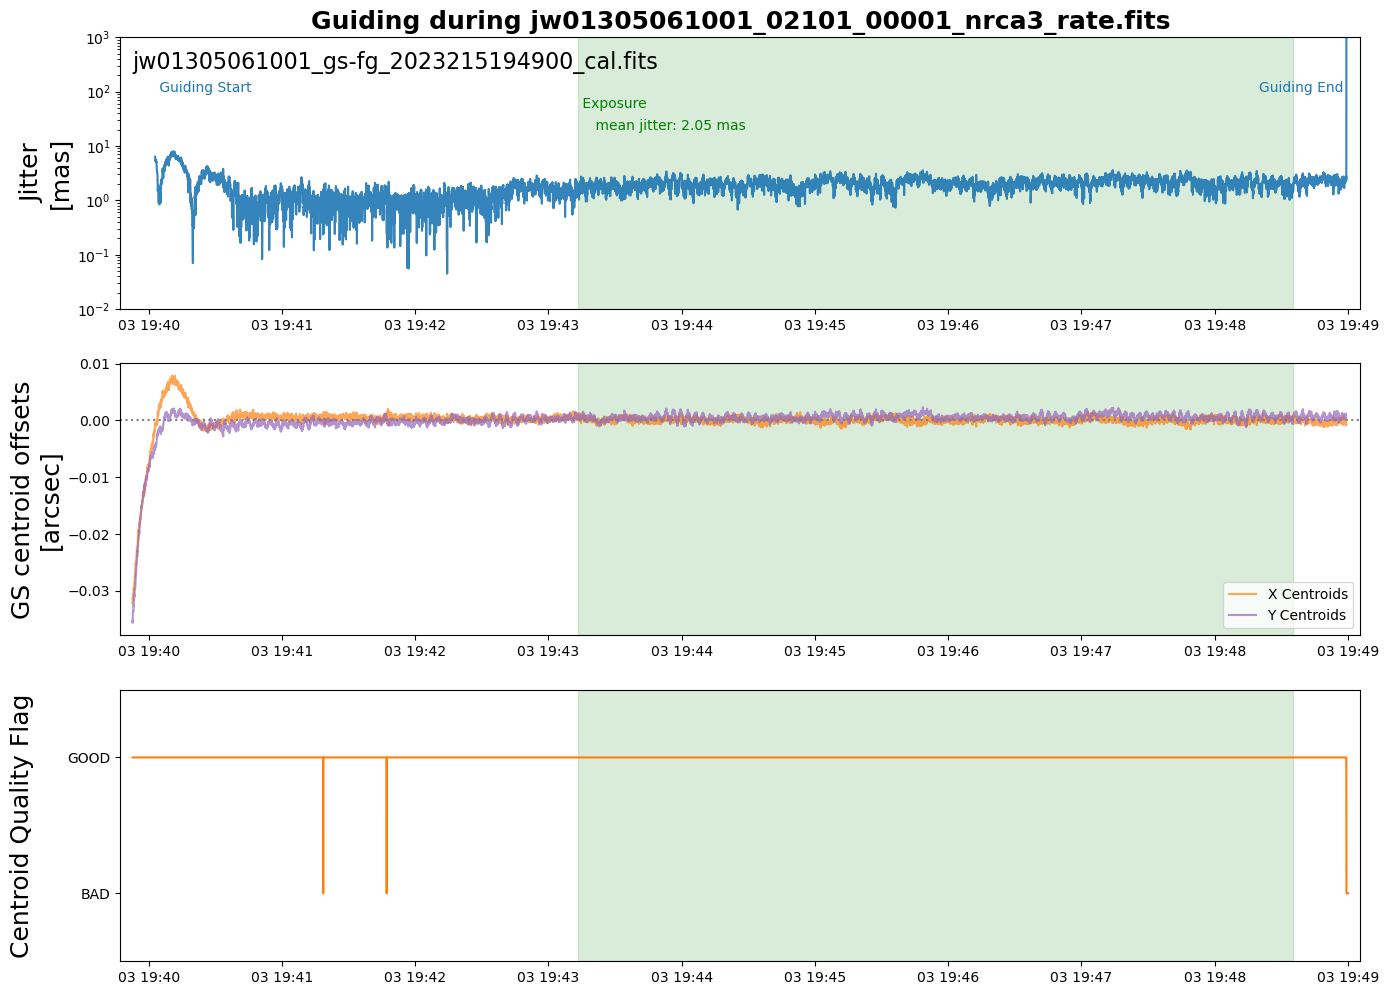

In [12]:
guiding_analyses.guiding_performance_plot(sci_filename)

For the exposure studied here, the pointing was quite stable. However, various disturbances and anomalies are possible, as discussed on a <A HREF="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#gsc.tab=0">JWST Documentation page for time series observations</A>. The <A HREF="https://github.com/GalagaBits/JWST-FGS-Spelunker">Spelunker</A> toolset provides functions for detailed investigations of these issues. Please read its <A HREF="https://jwst-fgs-spelunker.readthedocs.io">documentation</A> for instructions and illustrations of its use. This also uses some functions from the <A HREF="https://github.com/spacetelescope/jwstuser/">jwstuser</A> package, described in the <A HREF="https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-noise-sources#gsc.tab=0">JWST documentation</A>, which provides functionalities for querying JWST telemetry. 

<span style="color:red">TBD: The misc_jwst tools abopve only download the fine guide data products. So add here at the end the code snipppets from https://stsci-docs.stsci.edu/display/JDOX/.JWST+Fine+Guide+Stability+v4.0 that show how to download the data products for the other FGS functions, with a reference to https://stsci-docs.stsci.edu/display/JDOX/.JWST+Fine+Guide+Stability+v4.0 . Provide some indication for the kinds of circumstances when it may be useful to study these products.</span> 